## Group 24
Members: <br>
1) Arya Banerjee - 2021c104010 <br>
2) Ashwini Kumar Saurabh - 2021c104011 <br>
3) Rishabh Chowdhury - 2021c104023 <br>


Given Pickle file: https://drive.google.com/file/d/1-JvZrIgH3xVBV--yjiACQXaC-6-vQag8/view?usp=sharing
<br>
Image Dataset: https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## i.Import Libraries/Dataset

In [2]:
# Declare data paths and extracting the image files
data_dir='/content/drive/MyDrive/Colab Notebooks/data/'
image_dir_path = r'/content/Flicker8k_Dataset/Flicker8k_Dataset'
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/data/Image_captioning_Dataset.zip" -d "/content/Flicker8k_Dataset"

In [3]:
# Installing correct version of pytorch
!pip3 install torch==1.10.2 torchvision torchaudio torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

#### Validating Torch Version

In [5]:
import torch

print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

PyTorch version: 
1.10.2+cu102
CUDA Version: 
10.2
cuDNN version is: 
7605


#### Importing Required Libraries

In [6]:
import pickle
import pandas as pd
from PIL import Image
import time
import warnings

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import os
import pandas as pd
import spacy

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth=900

#### Checking GPU availability

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"GPU is available. Using {torch.cuda.get_device_name()} device.")
else:
  device = torch.device("cpu")
  print("GPU is not available. Using CPU device.")

GPU is available. Using Tesla T4 device.


## ii.Data Processing

### Convert the data into the correct format which could be used for the DL model.

In [8]:
# list image files present in the directory
image_list = os.listdir(image_dir_path)
print(image_list[:10])

['3326454455_960e5442e9.jpg', '493109089_468e105233.jpg', '3223606402_bb2aa6db95.jpg', '366713533_bd6d48cf02.jpg', '2978810122_183e60ff2d.jpg', '3621177753_1718c30ea0.jpg', '3230101918_7d81cb0fc8.jpg', '3391924827_53b31542ce.jpg', '3433982387_3fa993cf5a.jpg', '2837799692_2f1c50722a.jpg']


In [9]:
# open a file, where you stored the pickled data
file = open(data_dir+'set_4.pkl', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

# from pickle file loaded in 'data' dataframe with columns image and caption
df = pd.DataFrame(columns=["image","caption"])

for item in data:
    image_name = item.split('#')[0].replace('.jpg.1','.jpg')  # replacing invalid file extension with .jpg
    image_Caption=item.split('\t')[1]
    if image_name in image_list:                              # filtering out missing/invalid image names from the given pickle file
      df.loc[len(df)] = [image_name,image_Caption]

print(df.shape)

(24996, 2)


In [10]:
# Load the pickle file
with open(data_dir+'set_4.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary to store the image ids and captions
image_captions = {}

# Loop through the data and extract the image ids and captions
for item in data:
    # Extract the image id and caption
    image_id, caption = item.split('\t')
    # Remove any leading or trailing white space from the caption
    caption = caption.strip()
    # Extract the image name from the image id
    image_name = image_id.split('#')[0]
    # Add the image id and caption to the dictionary
    if image_name not in image_captions:
        image_captions[image_name] = []
    image_captions[image_name].append(caption)

# Print the first five entries in the dictionary
print(list(image_captions.items())[:5])

[('3312779887_7682db7827.jpg', ['A snowboarder do a trick off of a yellow pyramid .', 'A snowboarder hang upside down from his board during a maneuver in front of a crowd of person .']), ('2766926202_4201bf2bf9.jpg', ['Two man be play with glow stick and sparkler .', 'Two child wear glow necklace play with sparkler while stand in water .', 'Two child play with firework in shallow water', 'Two person be stand in shallow water , wave sparkler around']), ('244760301_5809214866.jpg', ['Several hiker walk along a rocky path .', 'A group of man wear similar clothing backpack through the countryside .', 'People walk', 'A group of person in matching outfit hike up a trail with one person lag behind .']), ('97105139_fae46fe8ef.jpg', ['Two person with head covering stand in a sandy field .', 'Two man in robe wave at an approach jeep travel through the sand .', 'Two man in keffiyahs stand next to car in the desert and wave at a pass vehicle .']), ('2646046871_c3a5dbb971.jpg', ['A child jump in th

### Plot at least two samples and their captions

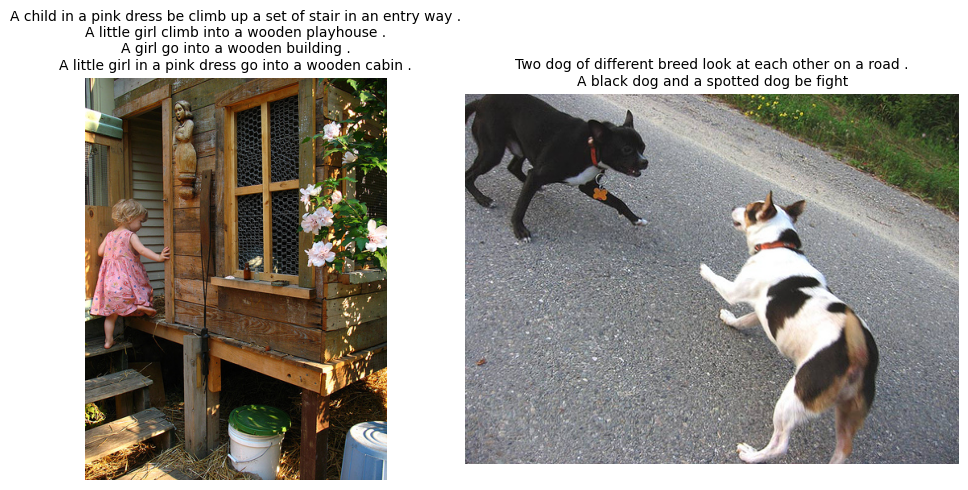

In [11]:
# Set the path to the images
img_path1='/content/Flicker8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
img_path2='/content/Flicker8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
img1 = Image.open(img_path1)
img2 = Image.open(img_path2)
img_name1=img_path1.split('/')[-1]
img_name2=img_path2.split('/')[-1]
# Create a figure and subplot for each image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the images and their captions
for ax, img_path, image_captions in zip(axs, [img_path1, img_path2], [image_captions[img_name1],image_captions[img_name2]]):
    # Load the image and display it
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    # Set the title of the subplot to the captions of the image
    ax.set_title('\n'.join(image_captions), fontsize=10)

plt.tight_layout()
plt.show()

### Load the data into train and test data in the required format.

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2)

df.to_csv(data_dir+'captions.txt',header=True, index=False)
train_df.to_csv(data_dir+'train_captions.txt',header=True, index=False)
test_df.to_csv(data_dir+'test_captions.txt',header=True, index=False)

## iii. Model Building

We have used **inception_v3** pretrained model for image feature
extraction.

In [13]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [14]:
# Converting text value to numerical values
# Vocabulary mapping required for each word to a index
# Pytorch dataset is required to load the data
# Need to Setup padding of every batch
# all examples need to be of the same seq_len and setup dataloader

# Download with: python -m spacy download en
spacy_eng = spacy.load('en_core_web_sm')


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

if __name__ == "__main__":
    transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

    loader, dataset = get_loader(
        "/content/Flicker8k_Dataset/Flicker8k_Dataset/", data_dir+"train_captions.txt", transform=transform
    )

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### We have Add one layer of dropout <br>
ReLU activation function is used for all the layers because it is computaionally efficient and it is a non linear activation function<br>


In [15]:
# model creation
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        #features = features.view(features.size(0), -1)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


### We have created a 2 layer LSTM model as mentioned in hyperparameter <br>
Loss function **CrossEntropyLoss** is used because it can handle imbalanced classes and it is efficient <br>
Optimizer **Adam** is used because of it adaptive learning rates

In [16]:
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, train_dataset = get_loader(
    root_folder="/content/Flicker8k_Dataset/Flicker8k_Dataset/",
    annotation_file=data_dir+"train_captions.txt",
    transform=transform,
    num_workers=2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 2
learning_rate = 3e-4
num_epochs = 30

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

## v. Model Training

• Train the model for an appropriate number of epochs. <br>
• Print the train and validation loss for each epoch. Use the appropriate batch size. <br>
• Plot the loss and accuracy history graphs for both train and validation set. <br>
• Print the total time taken for training. <br>

In [17]:
model.train()
start_time = time.time()
train_loss = 0.0
for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        ##imgs=imgs.ToTensor()
        imgs = imgs.to(device)
        ##captions=captions.ToTensor()
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
end_time = time.time()
execution_time = (end_time - start_time)/60.0


with open('/content/drive/MyDrive/Colab Notebooks/data/model_pkl', 'wb') as files:
     pickle.dump(model, files)

In [18]:
print("Model Trainining time:", execution_time, "minutes")

Model Trainining time: 248.56846944821456 minutes


### Print the model summary.

#### We have trained the model on 30 epochs
#### This model could have given much better results if it was trained on more epochs

#### Due to limited GPU availability in google colab, we have retricted it to 30 epochs

In [19]:
print('***Model Summary***')
print('embed_size:',embed_size)
print('hidden_size:',hidden_size)
print('vocab_size:',vocab_size)
print('num_layers:',num_layers)
print('learning_rate:',learning_rate)
print('num_epochs:',num_epochs)

***Model Summary***
embed_size: 256
hidden_size: 256
vocab_size: 2994
num_layers: 2
learning_rate: 0.0003
num_epochs: 30


In [20]:
# create an iterator object with write permission - model.pkl
with open('/content/drive/MyDrive/Colab Notebooks/data/model_pkl' , 'rb') as f:
    model = pickle.load(f)

## vi. Model Evaluation

Take 5 random images from Google and generate a caption for those images.

In [21]:
model.train()
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

model.eval()
pred_caption=[]
img_paths=[]
s=[]
image_names=['pick1.jpg','pick2.jpg','pick3.jpg','pick4.jpg','pick5.jpg']
for i,val in enumerate(image_names):
    image_path=data_dir+val
    img_paths.append(image_path)
    test_img = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
    caption=" ".join(model.caption_image(test_img.to(device), dataset.vocab))
    caption=caption.replace('<SOS>','').replace('<EOS>','')
    pred_caption.append(caption)

print(pred_caption)

[' a man in a red shirt and a white shirt is jumping up on his skateboard . ', ' a man in a red shirt climbs a rock face . ', ' a baseball player in a red uniform is running on the field . ', ' a man on a bike is riding a dirt bike . ', ' a man in a cowboy hat and jeans is riding a horse on a dirt road . ']


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


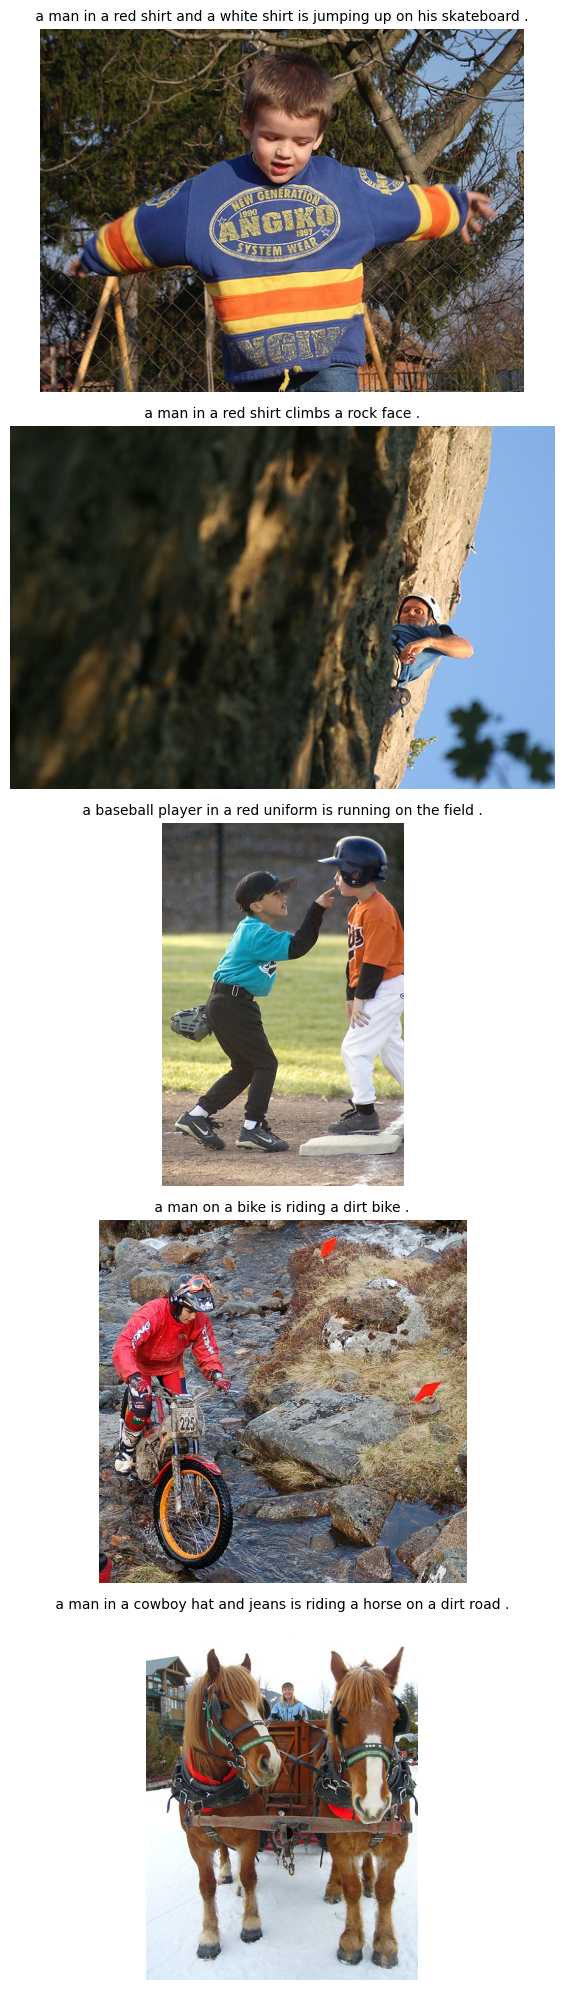

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot the images and their captions
for ax, img_path, image_captions in zip(axs, img_paths, pred_caption):
    # Load the image and display it
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    # Set the title of the subplot to the captions of the image
    ax.set_title(''.join(image_captions), fontsize=10)

plt.tight_layout()
plt.show()

In [26]:
test_df['predicted_Caption']=''
model.eval()
for index, row in test_df[:100].iterrows():
    #print(row["image"], row["caption"])
    image_path = image_dir_path+'/'+row["image"]
    #print(image_path)
    test_img = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
    pred_caption=" ".join(model.caption_image(test_img.to(device), dataset.vocab))
    pred_caption=pred_caption.replace('<SOS>','').replace('<EOS>','')
    #print(pred_caption)
    test_df.at[index,'predicted_Caption']=pred_caption

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [24]:
test_df.head(5)

,image,caption,predicted_Caption
1475,1454841725_4b6e6199e2.jpg,a group of young girl smile with a large crowd behind them,a group of people are standing in a crowd of people .
6021,2998861375_02817e0147.jpg,People dress in camo be bend down get ready to fire their gun .,a man in a white shirt and black shorts is playing with a dog .
15175,3565655045_8eb00b7423.jpg,A man be stand in the ocean and hold on tho a rock .,a man is standing on a rocky shore .
9519,2477623312_58e8e8c8af.jpg,A child in winter gear be pose while a crowd of person sit and stand behind her .,a young girl in a pink shirt is playing with a hula hoop .
15572,3420469425_2980b4cd30.jpg,A couple be hold their baby at a ceremony while a priest read his book,a group of people are standing in a crowd of people .


In [33]:
Actual_caption_list = list(test_df.caption)
Pred_caption_list = list(test_df.predicted_Caption)

print('BLEU score -> {}'.format(corpus_bleu(Actual_caption_list, Pred_caption_list )))
print('\n\n')

BLEU score -> 1.1183348024473232e-231



